In [1]:
import tensorflow as tf
import keras as k
from keras.layers import *
from keras.layers.convolutional import *
from keras.layers.convolutional_recurrent import *
from keras.layers.pooling import * 
from keras.layers.wrappers import *
from keras.models import Model
from keras import optimizers
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import pandas as pd
import pickle as pkl
from tqdm import tqdm
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pdk
from tqdm import tqdm
from multiprocessing import Pool
from datetime import datetime
import scipy.fftpack
from scipy.fftpack import fft
from keras.layers import Activation
from keras.activations import *
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.metrics import mean_squared_log_error, mean_squared_error
import re
import math

from keras.models import *
from keras.layers import *
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model, model_to_dot
from keras.regularizers import l2

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='gruvboxd', context='talk', fscale=1.4, spines=False, gridlines='--', ticks=True, grid=False, figsize=(6, 4.5))

#import hdf5 as h5

%matplotlib inline

Using TensorFlow backend.


In [32]:
with open('data/braintree_01_riser_prod.pkl', 'rb') as f:
    data = pkl.load(f)
    
supply_id = '00-0b-57-00-00-2d-e2-51'
return_id = '00-0b-57-00-00-2d-e2-cc'
time_interval = 60

supply_data = data[supply_id]
return_data = data[return_id]
assert (supply_data.shape == return_data.shape)
assert ((supply_data[:,0] == return_data[:,0]).all())



t = supply_data[:,0]
supply_data = supply_data[:,1]
return_data = return_data[:,1]

In [25]:
# Get time since midnight at t[0]
# This way, we can offset the quadrature time encoding such that midnight is 0 rad
quadrature_offset = (data['start_time'] - data['start_time'].replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()

combined_data = np.vstack([t, supply_data, return_data, np.sin(2*np.pi*t/86400), np.cos(2*np.pi*t/86400)]).T
assert (math.isclose(np.gradient(combined_data[:,0])[0], time_interval))

In [4]:
test_set_size = 1*24*60*60 # 1 day
#test_set_size = 15 # 15 minutes

end_time = t[-1]-test_set_size

train_data = [pt for pt in combined_data if pt[0] <= end_time]
test_data = [pt for pt in combined_data if pt[0] > end_time]
train_data = np.asarray(train_data)
test_data = np.asarray(test_data)

In [5]:
input_seq_length = 60 # 1h 
output_seq_length = 15 # 15m

# train set:
# X: 
# [supply, return, sin, cos] x input_seq_length
# Y:
# [supply, return] x output_seq_length

X_train = []
Y_train = []
X_test = []
Y_test = []

num_train_pts = train_data.shape[0]
train_end_iter = num_train_pts - input_seq_length - output_seq_length

for i in range(train_end_iter):
    input_start = i
    input_end = i + input_seq_length
    
    output_start = input_end + 1
    output_end = output_start + output_seq_length
    
    X_train.append(
        np.take(train_data[input_start:input_end], (1, 2, 3, 4), axis=1) # [supply, return, sin, cos]
    )
    Y_train.append(
        np.take(train_data[output_start:output_end], (1, 2), axis=1) # [supply, return]
    )

num_test_pts = test_data.shape[0]
test_end_iter = num_test_pts - input_seq_length - output_seq_length

for i in range(test_end_iter):
    input_start = i
    input_end = i + input_seq_length
    
    output_start = input_end + 1
    output_end = output_start + output_seq_length
    
    X_test.append(
        np.take(test_data[input_start:input_end], (1, 2, 3, 4), axis=1) # [supply, return, sin, cos]
    )
    Y_test.append(
        np.take(test_data[output_start:output_end], (1, 2), axis=1) # [supply, return]
    )

    
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

assert (X_train.shape == (train_end_iter, input_seq_length, 4))
assert (Y_train.shape == (train_end_iter, output_seq_length, 2))
assert (X_test.shape == (test_end_iter, input_seq_length, 4))
assert (Y_test.shape == (test_end_iter, output_seq_length, 2))

temp_max = np.max([supply_data, return_data])
temp_min = np.min([supply_data, return_data])

adj_fcn = lambda mtx: (((mtx-temp_min)/(temp_max-temp_min))-0.5)*2
X_train[:,:,:2] = adj_fcn(X_train[:,:,:2])
Y_train[:,:,:] = adj_fcn(Y_train[:,:,:])
X_test[:,:,:2] = adj_fcn(X_test[:,:,:2])
Y_test[:,:,:] = adj_fcn(Y_test[:,:,:])

X_train_quadrature = np.take(X_train, (2, 3), axis=2).reshape((train_end_iter, input_seq_length, 2))
X_train_supply = np.take(X_train, (0), axis=2).reshape((train_end_iter, input_seq_length, 1))
X_train_return = np.take(X_train, (1), axis=2).reshape((train_end_iter, input_seq_length, 1))
Y_train_supply = np.take(Y_train, (0), axis=2).reshape((train_end_iter, output_seq_length, 1))
Y_train_return = np.take(Y_train, (1), axis=2).reshape((train_end_iter, output_seq_length, 1))

X_test_quadrature = np.take(X_test, (2, 3), axis=2).reshape((test_end_iter, input_seq_length, 2))
X_test_supply = np.take(X_test, (0), axis=2).reshape((test_end_iter, input_seq_length, 1))
X_test_return = np.take(X_test, (1), axis=2).reshape((test_end_iter, input_seq_length, 1))
Y_test_supply = np.take(Y_test, (0), axis=2).reshape((test_end_iter, output_seq_length, 1))
Y_test_return = np.take(Y_test, (1), axis=2).reshape((test_end_iter, output_seq_length, 1))


100%|██████████| 2160/2160 [00:03<00:00, 689.34it/s]


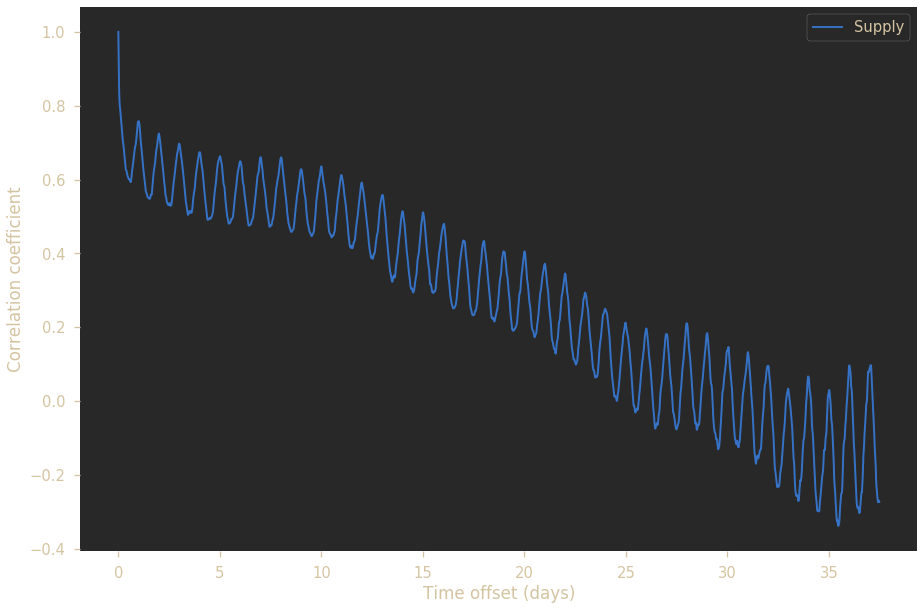

In [6]:
lag_min = 0
lag_max = len(combined_data[:,0])//2

def func_supply(lag):
    n = len(combined_data[:,1])
    c1 = combined_data[lag:,1]
    c2 = combined_data[:n-lag,1]
    corr = np.corrcoef(c1, c2)[0, 1]
    return [lag, corr]
def func_return(lag):
    n = len(combined_data[:,2])
    c1 = combined_data[lag:,2]
    c2 = combined_data[:n-lag,2]
    corr = np.corrcoef(c1, c2)[0, 1]
    return [lag, corr]

plt.rcParams['figure.figsize'] = [15, 10]

pts_supply = []
pts_return = []
for i in tqdm(range(lag_min, lag_max, 25)):
    pts_supply.append(func_supply(i))
    pts_return.append(func_return(i))
pts_supply = np.asarray(pts_supply)
pts_return = np.asarray(pts_return)
plt.plot(pts_supply[:,0]/(24*60), pts_supply[:,1])
#plt.plot(pts_return[:,0]/(24*60), pts_return[:,1])
plt.ylabel("Correlation coefficient")
plt.xlabel("Time offset (days)")
plt.legend(["Supply"])
#plt.show()
#below is supply data, time offset plotted, offset vs. correlation coefficient, could potentially predeict temperature from time of day

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


(0, 5)

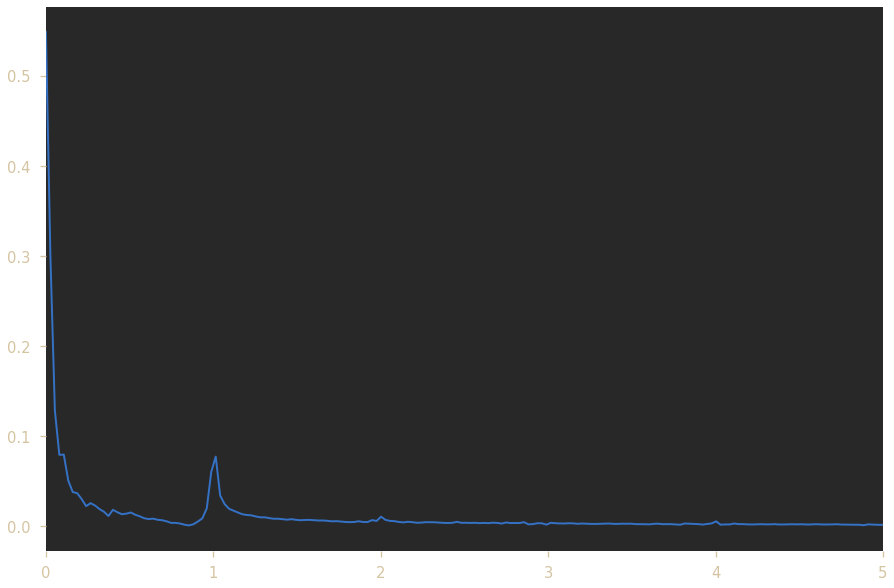

In [7]:
# Number of samplepoints
N = len(range(lag_min, lag_max, 25))
# sample spacing
T = pts_supply[1,0]/(24*60) - pts_supply[0,0]/(24*60)
x = pts_supply[:,0]/(24*60)
y = pts_supply[:,1]
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.xlim(0, 5)
#plt.show()
#took Fourier transform of above correlation, shows that 1 day of time has strong periodic pattern

W0819 18:46:52.027787 140482143229696 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:529: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 18:46:52.041176 140482143229696 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 18:46:52.042268 140482143229696 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4420: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



{'_op': <tf.Operation 'lstm3/transpose_1' type=Transpose>, '_value_index': 0, '_dtype': tf.float32, '_tf_output': <tensorflow.python.pywrap_tensorflow_internal.TF_Output; proxy of <Swig Object of type 'TF_Output *' at 0x7fc409a43b40> >, '_shape_val': None, '_consumers': [], '_id': 560, '_name': None, '_keras_shape': (None, 60, 32), '_uses_learning_phase': False, '_keras_history': (<keras.layers.recurrent.LSTM object at 0x7fc40a7a2d90>, 0, 0)}


W0819 18:46:52.789219 140482143229696 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



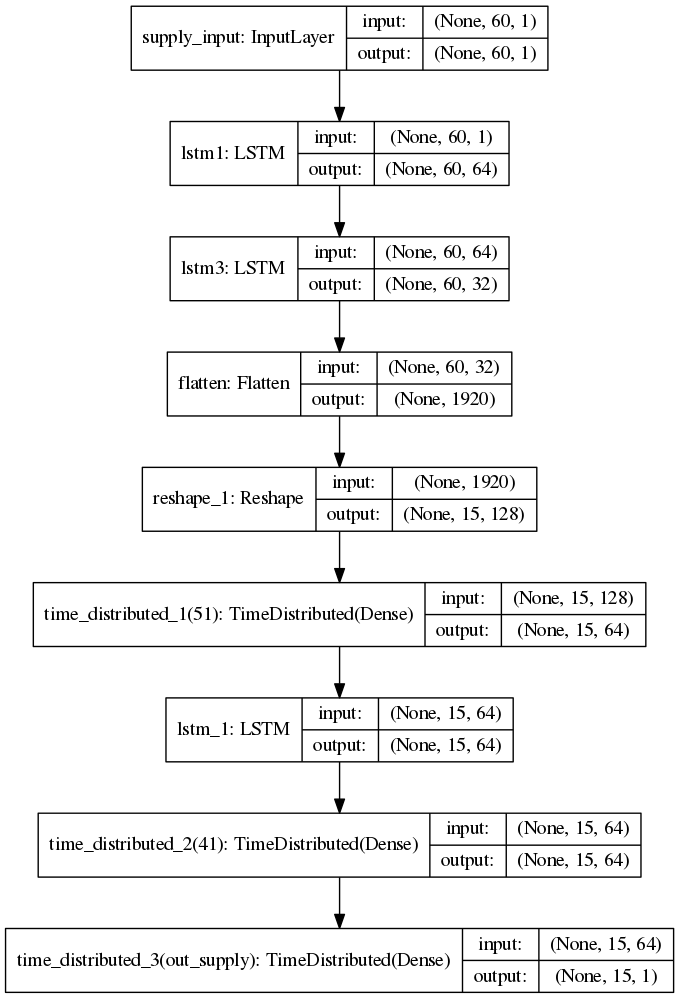

In [8]:
#building the model here, bulk of work on model configuration is done here
REG_DENSE = 1e-11
REG_LSTM = 1e-11
REG_LSTM2 = 1e-11
REG_OUT = 1e-11
DROPOUT = 0.1

# Quadrature direct testing:
# 32 -> 32 -> 32 -> 16: 3.1 loss
# 32 -> 32 -> 16: 3.1
# 32 -> 16: 3.12 loss


#input_time = Input(shape=(X_train_quadrature.shape[1], X_train_quadrature.shape[2]), name='time_input')
input_supply = Input(shape=(X_train_supply.shape[1], X_train_supply.shape[2]), name='supply_input')
#input_return = Input(shape=(X_train_return.shape[1], X_train_return.shape[2]), name='return_input')

#time_proc = TimeDistributed(Dense(32, activation='tanh', activity_regularizer=l2(REG_DENSE), name='quad_dense1'))(input_time)
#time_proc = TimeDistributed(Dense(16, activation='tanh', activity_regularizer=l2(REG_DENSE), name='quad_dense2'))(time_proc)

#merged = concatenate([time_proc, input_supply, input_return])

#keras function below LSTM
#activation function: relu (rectified linear) - all inputs multiplied by weighting and bias all summed in neuron and have output
#over fitting (memorized the training set too well without learning the underlying rules) - activity regulizer (give penalty to weight activities and bias, the bigger these magnitude, the bigger penalty)
#will return 60x64
lstm = LSTM(64, activation='relu', return_sequences=True, name='lstm1', activity_regularizer=l2(REG_LSTM))(input_supply)

#merged = concatenate([time_proc, lstm])
#we combine or "stack" two LSTMs here
#will return 60x32
lstm = LSTM(32, activation='relu', return_sequences=True, name='lstm3', activity_regularizer=l2(REG_LSTM))(lstm)

print(lstm.__dict__)
flat = Flatten(name='flatten')(lstm) #flatten returns 1920
#dropout = Dropout(DROPOUT, name='dropout1')(flat)
#dropout = Dropout(DROPOUT, name='dropout1')(reshape)

#resh_prox = Dense(15*64, activation='relu')(flat)
reshape = Reshape((15, 128))(flat)

#r_time = Reshape((15, 4))(input_supply)
#ccnt = concatenate([reshape, r_time])
ccnt = TimeDistributed(Dense(64, activation='relu', name='51', activity_regularizer=l2(REG_DENSE)))(reshape)

ccnt = LSTM(64, return_sequences=True, activation='relu', activity_regularizer=l2(REG_LSTM2))(ccnt)

dense = TimeDistributed(Dense(64, activation='relu', name='41', activity_regularizer=l2(REG_DENSE)))(ccnt)
#dense_del = TimeDistributed(Dense(64, name='1'))(dense)
#dense = add([dense, dense_del])
#dense = Activation('relu')(dense)
#dense = TimeDistributed(Dense(64, activation='relu', name='13'))(dense)
#dense_del = TimeDistributed(Dense(64, name='12'))(dense)
#dense = add([dense, dense_del])
#dense = Activation('relu')(dense)


def ode_gen(x):
    x_0 = x[0,0]
    x_1 = x[0,0]
    x_2 = x[0,0]
    x_3 = x[0,0]
    x_4 = x[0,0]
    out = []
    for i in range(15):
        x_3 += x_4
        x_2 += x_3
        x_1 += x_2
        x_0 += x_1
        out.append(x_0)
    return tf.convert_to_tensor(out)
    
out_supply = TimeDistributed(Dense(1,activation='linear', name='out_supply', activity_regularizer=l2(REG_OUT)))(dense)

l = lambda label, pred: K.mean(
    K.pow(K.abs(pred-label), 2) + K.pow(K.abs(pred-label)[15], 2)
)
l = lambda label,pred: K.mean(K.pow(K.abs(pred-label),8))

model = Model(input_supply, out_supply)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.0, amsgrad=False)
model.compile(loss='mse', optimizer=adam)

plt.rcParams['figure.figsize'] = [20, 20]

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=100)


In [35]:
#training model here from CSV file from above pkl file
logdir="/home/ubuntu/anomaly/tensorboard/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = k.callbacks.TensorBoard(log_dir=logdir)
lr_callback = k.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

history = model.fit(
    X_train_supply, 
    Y_train_supply, 
    epochs=30, 
    batch_size=1440,
    verbose=1,
    shuffle=True,
    validation_data=(X_test_supply, Y_test_supply),
    callbacks=[tensorboard_callback, lr_callback],
)

Train on 106485 samples, validate on 1365 samples
Epoch 1/30
106485/106485 [==============================] - 20s 188us/step - loss: 0.0043 - val_loss: 0.0032
Epoch 2/30
106485/106485 [==============================] - 20s 188us/step - loss: 0.0043 - val_loss: 0.0032
Epoch 3/30
106485/106485 [==============================] - 20s 187us/step - loss: 0.0043 - val_loss: 0.0032
Epoch 4/30
106485/106485 [==============================] - 20s 187us/step - loss: 0.0043 - val_loss: 0.0032
Epoch 5/30
106485/106485 [==============================] - 20s 187us/step - loss: 0.0043 - val_loss: 0.0032
Epoch 6/30
 21600/106485 [=====>........................] - ETA: 15s - loss: 0.0043

KeyboardInterrupt: 

In [26]:
#running (inferring) the model on the same set
#testing on same sensor but for data that it has not seen before
pred = model.predict(X_test_supply, verbose=1, batch_size=3000)
s = pred
#s = pred

1365/1365 [==============================] - 0s 67us/step


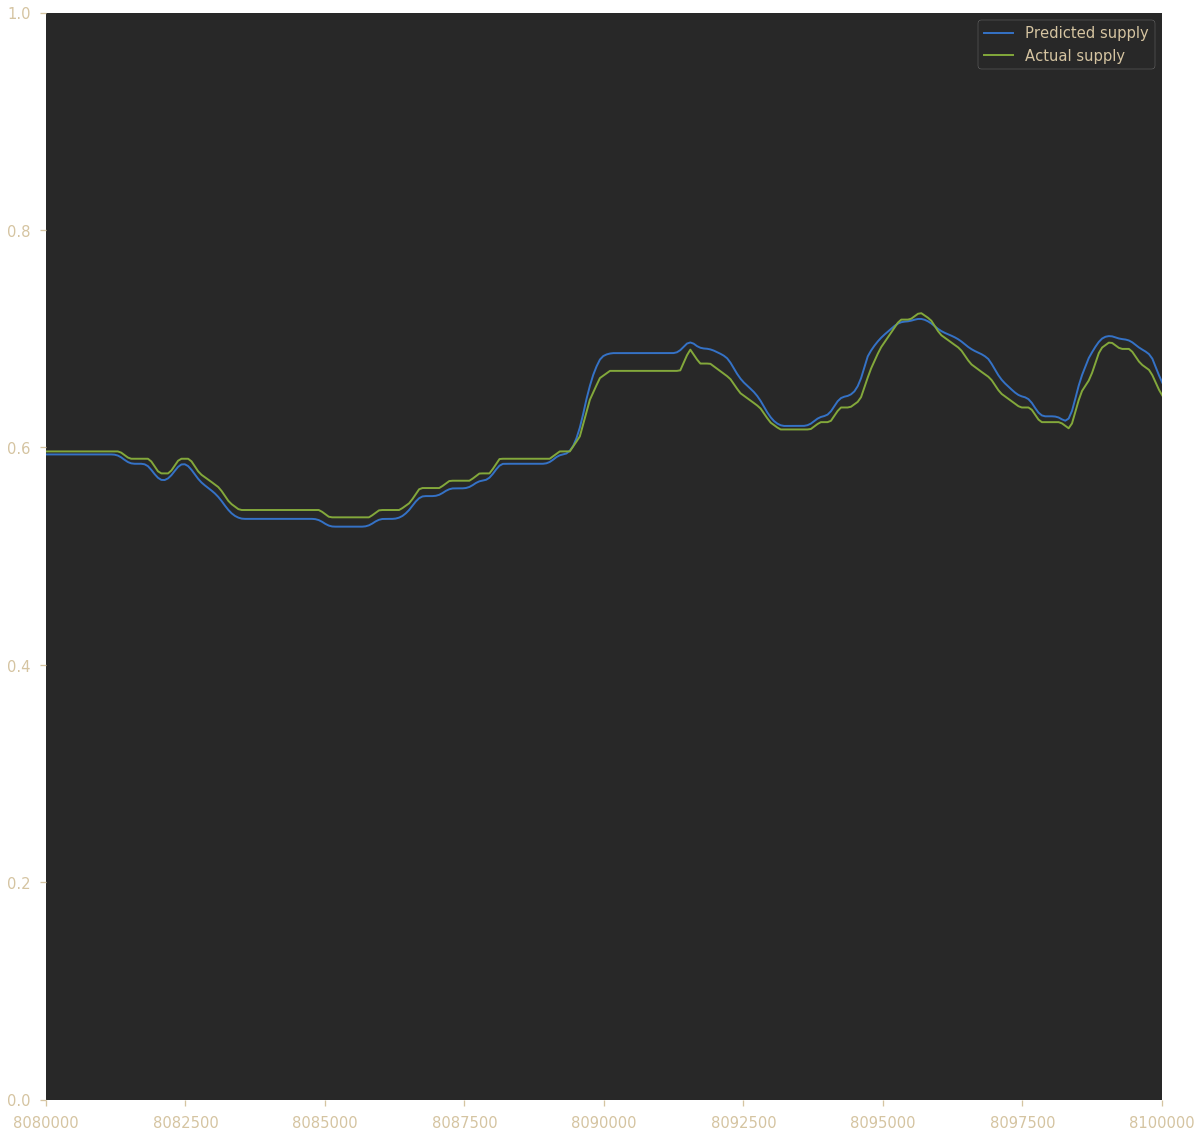

In [27]:
plt.rcParams['figure.figsize'] = [20, 20]


plt.plot(test_data[:test_end_iter,0], s[:,0])
#plt.plot(test_data[:test_end_iter,0], r[:,0])
plt.plot(test_data[:test_end_iter,0]-60, X_test_supply[:test_end_iter,0])
#plt.plot(test_data[:test_end_iter,0], X_test_return[:test_end_iter, 0])
#plt.plot(test_data[:test_end_iter,0], X_test_quadrature[:,:,0])
#plt.plot(test_data[:test_end_iter,0], X_test_quadrature[:,:,1])
plt.legend(["Predicted supply", "Actual supply"])
plt.xlim([8080000, 8100000])
plt.ylim([0, 1])

plt.show()

In [28]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plotAtIdx(idx, offset):

    plt.plot(test_data[:idx,0], s[:idx,0])
   # plt.plot(test_data[:idx,0], r[:idx,0])
    plt.plot(test_data[idx:idx+output_seq_length,0], s[idx,:])
   # plt.plot(test_data[idx:idx+output_seq_length,0], r[idx,:])
    plt.plot(test_data[:test_end_iter,0], X_test_supply[:test_end_iter,0])
   # plt.plot(test_data[:test_end_iter,0], X_test_return[:test_end_iter, 0])
    #plt.plot(test_data[:test_end_iter,0], X_test_quadrature[:,:,0])
    #plt.plot(test_data[:test_end_iter,0], X_test_quadrature[:,:,1])
    plt.legend(["Predicted supply", "Predicted return", "Predicted future supply", "Predicted future return", "Actual supply", "Actual return"])
    plt.xlim([8080000, 8100000])
    plt.plot([test_data[idx,0], test_data[idx,0]], [0, 1], '|--w')

    plt.show()
    #test_data[1200,0]
    
interact(plotAtIdx, idx=widgets.IntSlider(min=800, max=1495, step=1, value=1247), offset=widgets.FloatSlider(min=0, max=0.1, step=0.0001, value=0.03))

interactive(children=(IntSlider(value=1247, description='idx', max=1495, min=800), FloatSlider(value=0.03, des…

<function __main__.plotAtIdx(idx, offset)>

In [29]:
with open('data/wyndham_13_riser_supply_interp.pkl', 'rb') as f:
        val_set = pkl.load(f)


t_val = val_set[:,0]
supply_val = val_set[:,1]
input_seq_length = 60 # 1h 
output_seq_length = 15 # 15m
val_data = val_set
# train set:
# X: 
# [supply, return, sin, cos] x input_seq_length
# Y:
# [supply, return] x output_seq_length

X_val = []
Y_val = []

num_train_pts = val_set.shape[0]
val_end_iter = num_train_pts - input_seq_length - output_seq_length

for i in range(train_end_iter):
    input_start = i
    input_end = i + input_seq_length
    
    output_start = input_end + 1
    output_end = output_start + output_seq_length
    
    X_val.append(
        np.take(val_data[input_start:input_end], (1), axis=1) # [supply, return, sin, cos]
    )
    Y_val.append(
        np.take(val_data[output_start:output_end], (1), axis=1) # [supply, return]
    )

X_val = np.asarray(X_val).reshape((val_end_iter, input_seq_length, 1))
Y_val = np.asarray(Y_val).reshape((val_end_iter, output_seq_length, 1))

assert (X_val.shape == (val_end_iter, input_seq_length, 1))
assert (Y_val.shape == (train_end_iter, output_seq_length, 1))

X_val = adj_fcn(X_val)
Y_val = adj_fcn(Y_val)

ValueError: cannot reshape array of size 106485 into shape (23725,60,1)

In [ ]:
val_data.shape

In [31]:
pred = model.predict(X_val, verbose=1, batch_size=3000)
v = pred


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 106485 arrays: [array([[118.93418428],
       [118.12020214],
       [117.0426502 ],
       [116.24000179],
       [115.62551527],
       [114.24244995],
       [112.99476278],
       [112.58213786],
       [112.749...

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plotAtIdx(idx, offset):
    plt.plot(val_data[-60*24:-idx,0], v[-60*24:-idx,0])
    plt.plot(val_data[-60*24:,0], X_val[-60*24:, 0, 0])
    plt.plot(val_data[-idx:-idx+output_seq_length,0], v[idx,:])
  
# plt.plot(val_data[:-75,0], v[:,0])
    plt.legend(["Predicted supply", "Predicted return", "Predicted future supply", "Predicted future return", "Actual supply", "Actual return"])
    plt.ylim(-1, 6)
    #plt.xlim([85687200-60*24*7, 85687200])
    #plt.plot([val_data[idx,0], val_data[idx,0]], [0, 1], '|--w')

    plt.show()
    #test_data[1200,0]
    
interact(plotAtIdx, idx=widgets.IntSlider(min=0, max=1500, step=1, value=1000), offset=widgets.FloatSlider(min=0, max=0.1, step=0.0001, value=0.03))

In [ ]:
val_data[-1,0]*60